<a href="https://www.kaggle.com/code/anirudhrangu/cs6350?scriptVersionId=271858866" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# KITTI Dataset Visualization

In this step, we:
1. **Load** stereo image pairs (left and right camera) from the KITTI dataset.
2. **Read** the corresponding calibration text file to extract:
   - The **rotation matrix (R)**
   - The **translation vector (t)**
3. **Display** a few sample images with their R and t values to confirm that data loading is correct.

This helps us ensure that the image data and ground-truth poses are aligned before moving into keypoint detection and pose estimation.


In [36]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from mpl_toolkits.mplot3d import Axes3D

In [37]:
base_dir = "/kaggle/input/kitti-dataset"  
left_dir = os.path.join(base_dir, "data_object_image_2/training/image_2/000000.png")  # left camera images
pose_file = os.path.join(base_dir, "data_object_label_2/training/label_2/000000.txt")  # pose file

In [38]:
import pandas as pd

def parse_kitti_label_file(label_path):

    columns = [
        "type", "truncated", "occluded", "alpha",
        "bbox_xmin", "bbox_ymin", "bbox_xmax", "bbox_ymax",
        "height", "width", "length",
        "pos_x", "pos_y", "pos_z",
        "rotation_y"
    ]
    
    data = []

    try:
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if parts[0] == "DontCare":
                    continue  # skip non-labeled regions
                values = parts[:15]  # ensure only 15 fields are taken
                data.append(values)
        
        # Convert to DataFrame
        df = pd.DataFrame(data, columns=columns)
        
        # Convert numeric columns to float
        for col in columns[1:]:
            df[col] = df[col].astype(float)
        
        return df
    except:
        with exception as e:
            print("error:", e)

# Example usage:
label_file = "/kaggle/input/kitti-dataset/data_object_label_2/training/label_2/000001.txt"
df = parse_kitti_label_file(label_file)
print(df.head())


      type  truncated  occluded  alpha  bbox_xmin  bbox_ymin  bbox_xmax  \
0    Truck        0.0       0.0  -1.57     599.41     156.40     629.75   
1      Car        0.0       0.0   1.85     387.63     181.54     423.81   
2  Cyclist        0.0       3.0  -1.65     676.60     163.95     688.98   

   bbox_ymax  height  width  length  pos_x  pos_y  pos_z  rotation_y  
0     189.25    2.85   2.63   12.34   0.47   1.49  69.44       -1.56  
1     203.12    1.67   1.87    3.69 -16.53   2.39  58.49        1.57  
2     193.93    1.86   0.60    2.02   4.59   1.32  45.84       -1.55  


## KITTI Dataset File Structure

The KITTI dataset stores training images, labels, and calibration files as follows:

- `training/image_2/`: Left color images (used for object detection)
- `training/label_2/`: Labels for each image; each line contains object class, truncation, occlusion, alpha, bounding box, 3D dimensions, 3D location, rotation
- `training/calib/`: Calibration files per image

In this notebook, we start with the object detection step:
- Read an image
- Load its label file
- Draw the ground truth bounding boxes

Next steps will include feature extraction and further pose estimation.


In [46]:
!pip install ultralytics

In [40]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO

# Base KITTI dataset directory (adjust if needed)
KITTI_BASE = '/kaggle/input/kitti-dataset'

# Dataset folders
RIGHT_IMG_DIR = os.path.join(KITTI_BASE, 'data_object_image_2', 'training', 'image_2')
LEFT_IMG_DIR = os.path.join(KITTI_BASE, 'data_object_image_3', 'training', 'image_3')
CALIB_DIR = os.path.join(KITTI_BASE, 'data_object_calib', 'training', 'calib')
LABEL_DIR = os.path.join(KITTI_BASE, 'data_object_label_2', 'training', 'label_2')

def load_calibration(file_path):
    calib_data = {}
    with open(file_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if ':' not in line:
                continue
            key, value = line.split(':', 1)
            values = np.array([float(v) for v in value.split()])
            if key.startswith('R') and values.size == 9:
                calib_data[key] = values.reshape(3, 3)
            elif values.size == 12:
                calib_data[key] = values.reshape(3, 4)
            else:
                calib_data[key] = values
    return calib_data

def load_labels(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()
    labels = []
    for line in lines:
        parts = line.strip().split(' ')
        if parts[0] == 'DontCare':
            continue
        labels.append({
            'class': parts[0],
            'truncation': float(parts[1]),
            'occlusion': int(parts[2]),
            'alpha': float(parts[3]),
            'bbox': list(map(float, parts[4:8])),  # 2D bbox
            'dimensions': list(map(float, parts[8:11])),
            'location': list(map(float, parts[11:14])),
            'rotation_y': float(parts[14])
        })
    return labels

def draw_bboxes(image, boxes, labels=None, color=(0,255,0), with_labels=True):
    img = image.copy()
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img, (x1,y1), (x2,y2), color, 2)
        if with_labels and labels:
            label = labels[i] if isinstance(labels[i], str) else str(labels[i])
            cv2.putText(img, label, (x1, y1 - 7), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    return img

# Load YOLOv8 once
model = YOLO('yolov8l.pt')


In [41]:
def union_detections(boxes_left, boxes_right, iou_threshold=0.1):
    union_indices_left = set()
    union_indices_right = set()

    for i, boxL in enumerate(boxes_left):
        matched = False
        for j, boxR in enumerate(boxes_right):
            xA = max(boxL[0], boxR[0])
            yA = max(boxL[1], boxR[1])
            xB = min(boxL[2], boxR[2])
            yB = min(boxL[3], boxR[3])
            interArea = max(0, xB - xA) * max(0, yB - yA)
            boxLArea = (boxL[2] - boxL[0]) * (boxL[3] - boxL[1])
            boxRArea = (boxR[2] - boxR[0]) * (boxR[3] - boxR[1])
            iou = interArea / float(boxLArea + boxRArea - interArea) if (boxLArea + boxRArea - interArea) > 0 else 0
            if iou > iou_threshold:
                union_indices_left.add(i)
                union_indices_right.add(j)
                matched = True
        if not matched:
            union_indices_left.add(i)

    for j, boxR in enumerate(boxes_right):
        matched = False
        for i, boxL in enumerate(boxes_left):
            xA = max(boxL[0], boxR[0])
            yA = max(boxL[1], boxR[1])
            xB = min(boxL[2], boxR[2])
            yB = min(boxL[3], boxR[3])
            interArea = max(0, xB - xA) * max(0, yB - yA)
            boxLArea = (boxL[2] - boxL[0]) * (boxL[3] - boxL[1])
            boxRArea = (boxR[2] - boxR[0]) * (boxR[3] - boxR[1])
            iou = interArea / float(boxLArea + boxRArea - interArea) if (boxLArea + boxRArea - interArea) > 0 else 0
            if iou > iou_threshold:
                matched = True
                break
        if not matched:
            union_indices_right.add(j)

    return sorted(list(union_indices_left)), sorted(list(union_indices_right))

In [42]:
def bbox_iou(boxA, boxB):
    # box = [x1,y1,x2,y2]
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA + 1)*max(0, yB - yA + 1)
    boxAArea = (boxA[2] - boxA[0] + 1)*(boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1)*(boxB[3] - boxB[1] + 1)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

def match_detections(boxes_left, boxes_right, iou_threshold=0.5):
    matches = []
    for i, boxL in enumerate(boxes_left):
        for j, boxR in enumerate(boxes_right):
            if bbox_iou(boxL, boxR) > iou_threshold:
                matches.append((i,j))
    return matches

In [43]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def extract_sift_features(image, boxes, matched_indices):
    """
    Extract SIFT features from matched detection bounding boxes.
    """
    sift = cv2.SIFT_create()
    features = []

    for idx in matched_indices:
        box = boxes[idx]
        x1, y1, x2, y2 = map(int, box)
        roi = image[y1:y2, x1:x2]

        if roi.size == 0:
            continue  # skip invalid boxes

        # Convert to grayscale for SIFT
        gray_roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)

        keypoints, descriptors = sift.detectAndCompute(gray_roi, None)
        if keypoints:
            # Offset keypoint coordinates to global image space
            for kp in keypoints:
                kp.pt = (kp.pt[0] + x1, kp.pt[1] + y1)
        features.append({
            'keypoints': keypoints,
            'descriptors': descriptors,
            'bbox': box
        })

    return features


def draw_keypoints(image, features, color=(255, 0, 255)):
    """
    Draw detected keypoints on image using OpenCV.
    """
    img = image.copy()

    # Convert RGB to BGR for cv2 drawing functions
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    for f in features:
        kps = f.get('keypoints', [])
        if kps:
            img_bgr = cv2.drawKeypoints(img_bgr, kps, None, color=color, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Convert back to RGB for matplotlib display
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    return img_rgb


In [44]:
def match_features(features_left, features_right, ratio_thresh=0.75):
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    matched_pairs = []

    for f_left, f_right in zip(features_left, features_right):
        des1 = f_left['descriptors']
        des2 = f_right['descriptors']

        if des1 is None or des2 is None:
            matched_pairs.append([])
            continue
        
        matches = bf.knnMatch(des1, des2, k=2)

        good_matches = []
        for m, n in matches:
            if m.distance < ratio_thresh * n.distance:
                good_matches.append(m)
        matched_pairs.append(good_matches)
    return matched_pairs

def draw_matches(img1, kp1, img2, kp2, matches):
    matched_img = cv2.drawMatches(img1, kp1, img2, kp2, matches, None,
                                  flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(16,8))
    plt.imshow(matched_img)
    plt.title('Feature Matches (First Matched Object)')
    plt.axis('off')
    plt.show()

In [51]:
def extract_intrinsics(P):
    """Extract intrinsic matrix K from camera projection matrix P (3x4)."""
    K, R, t, _, _, _, _ = cv2.decomposeProjectionMatrix(P)
    K = K / K[2, 2]  # Normalize so K[2,2] = 1
    return K

def normalize_points(pts, K):
    """Convert pixel points to normalized coordinates by inverting K."""
    pts_h = cv2.convertPointsToHomogeneous(pts).reshape(-1, 3).T  # 3xN
    pts_norm = np.linalg.inv(K) @ pts_h                            # 3xN normalized
    return pts_norm[:2].T                                          # Nx2

In [67]:
def stereo_rectify_and_compute_disparity(left_img, right_img, K_left, K_right, R, t, img_size):
    # Distortion coefficients assumed zero due to KITTI rectified images
    D_left = np.zeros(5)
    D_right = np.zeros(5)

    R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(
        K_left, D_left, K_right, D_right, img_size, R, t, flags=cv2.CALIB_ZERO_DISPARITY, alpha=0)

    # Prepare rectification maps
    map1x, map1y = cv2.initUndistortRectifyMap(K_left, D_left, R1, P1, img_size, cv2.CV_16SC2)
    map2x, map2y = cv2.initUndistortRectifyMap(K_right, D_right, R2, P2, img_size, cv2.CV_16SC2)

    # Remap images
    rectified_left = cv2.remap(left_img, map1x, map1y, interpolation=cv2.INTER_LINEAR)
    rectified_right = cv2.remap(right_img, map2x, map2y, interpolation=cv2.INTER_LINEAR)

    # Create StereoSGBM matcher
    window_size = 5
    min_disp = 0
    num_disp = 16*8  # must be divisible by 16
    stereo = cv2.StereoSGBM_create(
        minDisparity=min_disp,
        numDisparities=num_disp,
        blockSize=window_size,
        P1=8*3*window_size**2,
        P2=32*3*window_size**2,
        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY)

    # Compute disparity (raw)
    disparity = stereo.compute(rectified_left, rectified_right).astype(np.float32) / 16.0

    return rectified_left, rectified_right, disparity, Q

def draw_horizontal_epilines(img, line_interval=40, color=(0,255,0)):
    img_epilines = img.copy()
    h, w = img_epilines.shape[:2]
    for y in range(0, h, line_interval):
        cv2.line(img_epilines, (0, y), (w, y), color, 1)
    return img_epilines


In [75]:
def filter_point_cloud(points_3d, disparity, min_depth=0.5, max_depth=50.0):
    # Create a 2D mask for valid disparity
    disparity_mask = disparity > disparity.min()
    # Retrieve Z (depth) component of 3D points
    depth = points_3d[:, :, 2]
    # Create depth validity mask
    depth_mask = (depth > min_depth) & (depth < max_depth)
    # Combine masks
    combined_mask = disparity_mask & depth_mask
    # Return filtered points as Nx3 array
    return points_3d[combined_mask]


def extract_points_for_object(points_3d, bbox, img_shape):
    x1, y1, x2, y2 = map(int, bbox)
    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(img_shape[1] - 1, x2)
    y2 = min(img_shape[0] - 1, y2)
    
    # Extract points inside bbox (assumed points_3d mapped to image grid)
    obj_points = points_3d[y1:y2+1, x1:x2+1, :]
    obj_points_flat = obj_points.reshape(-1, 3)
    # Filter invalid points
    obj_points_filtered = obj_points_flat[obj_points_flat[:,2] > 0]
    return obj_points_filtered

def plot_3d_points(points_3d, title='3D Points'):
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], s=1)
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')
    ax.set_title(title)
    plt.show()

In [85]:
def estimate_pose_from_matches(pts_left, pts_right, K):
    """
    Given matched points and camera intrinsic matrix K,
    compute Fundamental and Essential matrices, then recover pose.
    
    Inputs:
    - pts_left: Nx2 numpy array of matched points in left image
    - pts_right: Nx2 numpy array of matched points in right image
    - K: 3x3 camera intrinsic matrix
    
    Outputs:
    - F: Fundamental matrix (3x3)
    - E: Essential matrix (3x3)
    - R: Rotation matrix (3x3)
    - t: Translation vector (3x1)
    """
    # Compute Fundamental matrix using matched points with RANSAC
    F, mask_F = cv2.findFundamentalMat(pts_left, pts_right, method=cv2.FM_RANSAC)

    # Compute Essential matrix from Fundamental matrix and camera intrinsics: E = K'.T * F * K
    E = K.T @ F @ K

    # Decompose Essential matrix to get relative pose
    _, R, t, mask_pose = cv2.recoverPose(E, pts_left, pts_right, K)

    return F, E, R, t

def rotation_yaw_from_R(R):
    # Compute yaw from rotation matrix R 
    return np.arctan2(R[2, 0], R[0, 0])

=== Running KITTI Analysis for Image ID: 000002 ===


0: 224x640 2 trucks, 810.4ms
Speed: 2.5ms preprocess, 810.4ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 640)

0: 224x640 1 car, 2 trucks, 779.7ms
Speed: 2.5ms preprocess, 779.7ms inference, 1.5ms postprocess per image at shape (1, 3, 224, 640)


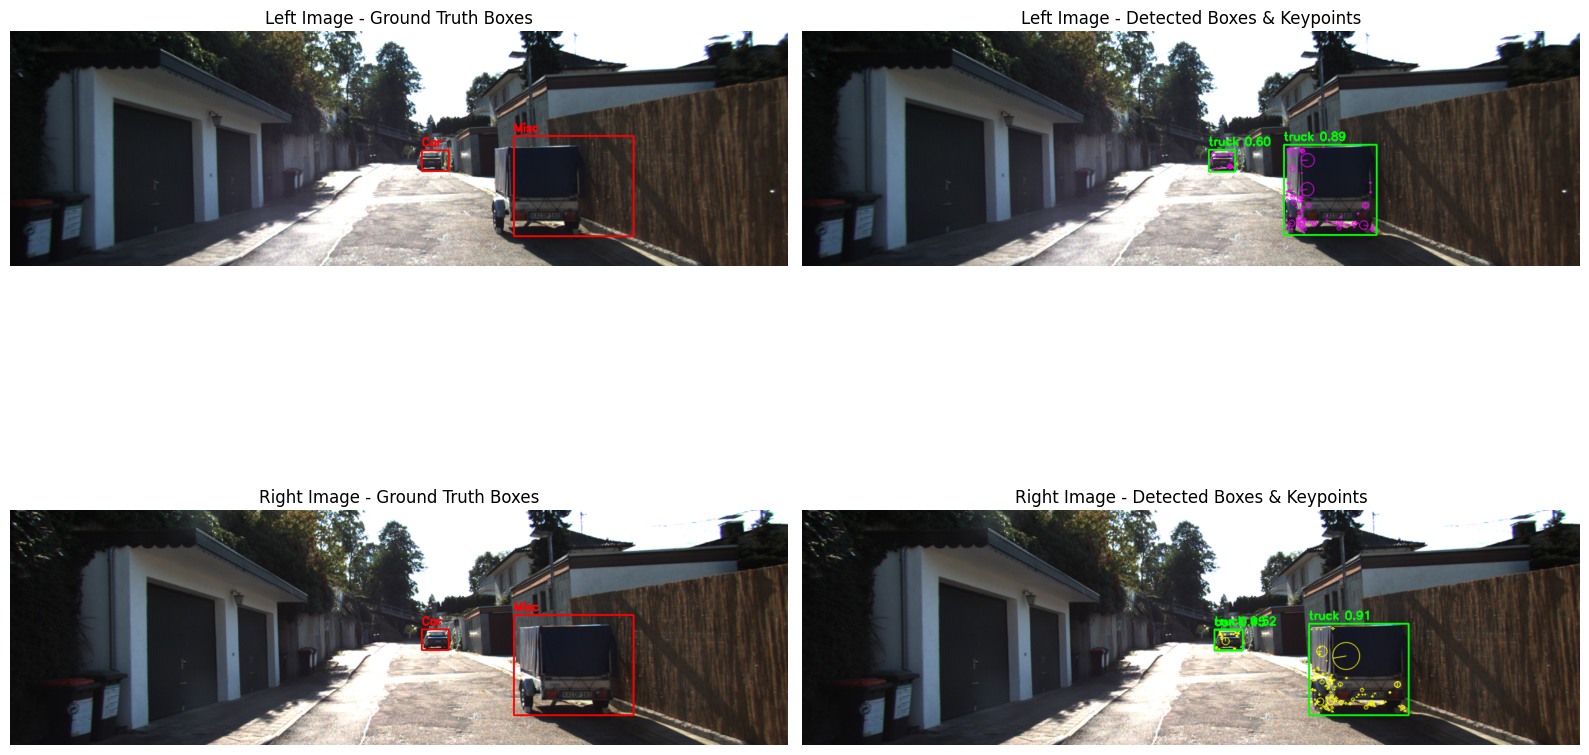

Visualizing 43 matches for first matched object


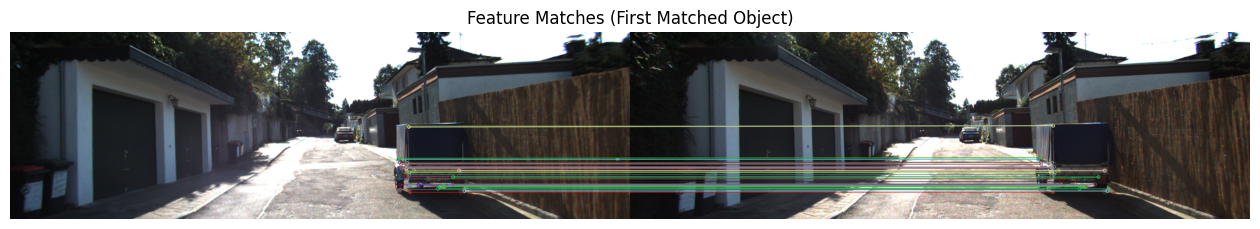


Camera Intrinsic matrix K_left:
[[     721.54           0      609.56]
 [          0      721.54      172.85]
 [          0           0           1]]

Camera Intrinsic matrix K_right:
[[     721.54           0      609.56]
 [          0      721.54      172.85]
 [          0           0           1]]

Estimated Essential Matrix:
[[  0.0054807    -0.34218   -0.010798]
 [    0.26346   0.0014875     0.65612]
 [    0.01756    -0.61851 -0.00046373]]
Recovered Rotation:
[[    0.99232    0.012008     0.12313]
 [  -0.012439     0.99992   0.0027279]
 [   -0.12309  -0.0042386     0.99239]]
Recovered Translation:
[[   -0.87495]
 [  -0.014057]
 [    0.48401]]

Estimated yaw (radians): -0.12341362892914391
Ground truth yaw (radians): -1.47
Angular difference between translation directions (radians): 1.4313108911252932


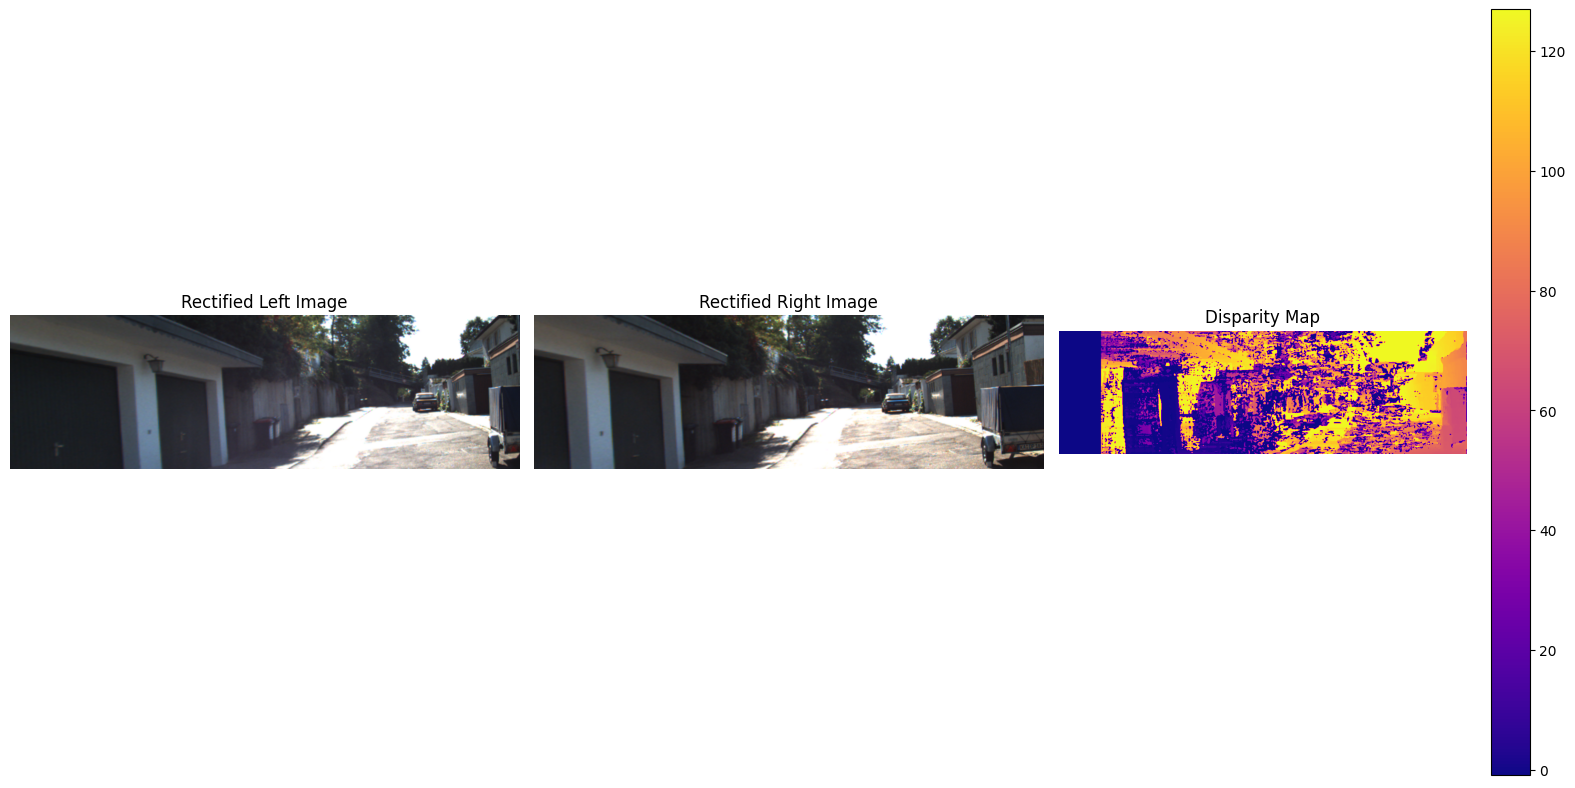


Valid dense 3D points count: 267162
Object 0 - valid 3D points: 22464


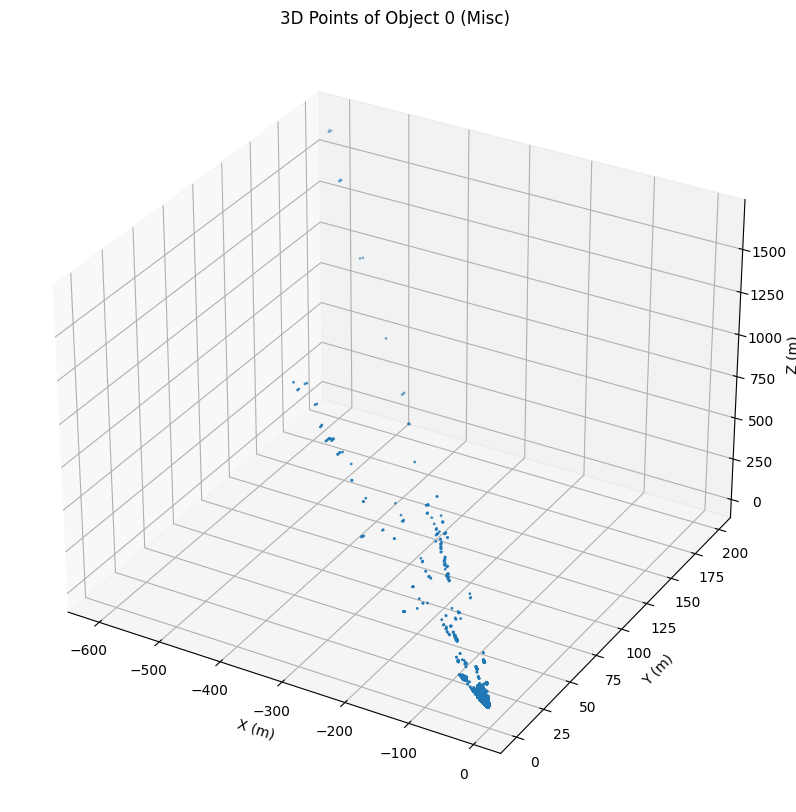

Object 1 - valid 3D points: 472


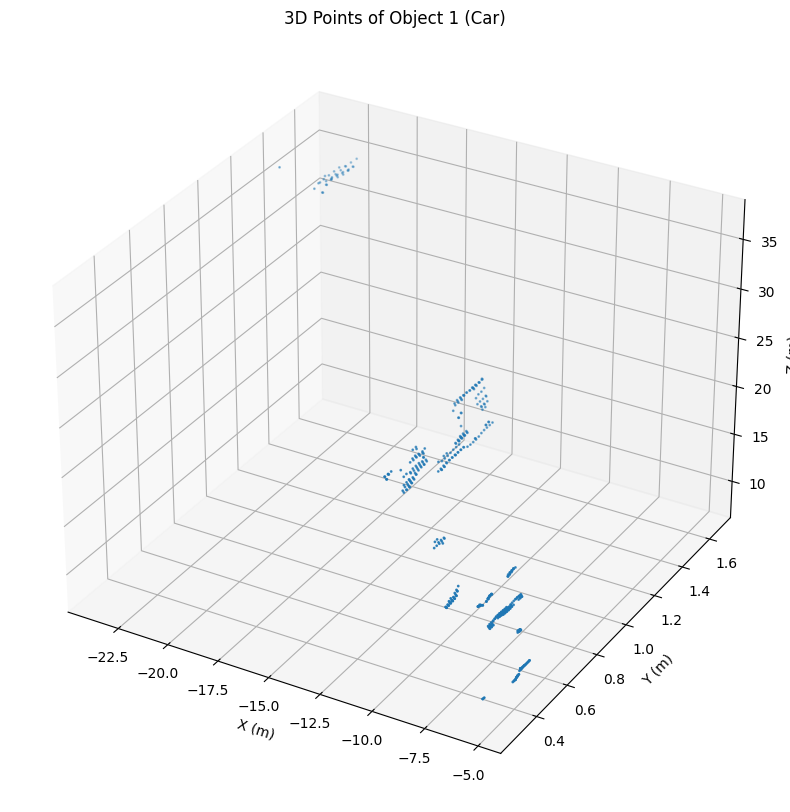


=== Calibration Matrices ===
P0:
[[     721.54           0      609.56           0]
 [          0      721.54      172.85           0]
 [          0           0           1           0]]

P1:
[[     721.54           0      609.56     -387.57]
 [          0      721.54      172.85           0]
 [          0           0           1           0]]

P2:
[[     721.54           0      609.56      44.857]
 [          0      721.54      172.85     0.21638]
 [          0           0           1   0.0027459]]

P3:
[[     721.54           0      609.56     -339.52]
 [          0      721.54      172.85      2.1999]
 [          0           0           1   0.0027299]]

R0_rect:
[[    0.99992   0.0098378   -0.007445]
 [ -0.0098698     0.99994  -0.0042785]
 [  0.0074025   0.0043516     0.99996]]

Tr_velo_to_cam:
[[  0.0075337    -0.99997  -0.0006166  -0.0040698]
 [   0.014802  0.00072807    -0.99989   -0.076316]
 [    0.99986   0.0075238    0.014808    -0.27178]]

Tr_imu_to_velo:
[[          1  0.00

In [86]:
def run_kitti_analysis(img_id):
    print(f"=== Running KITTI Analysis for Image ID: {img_id} ===\n")

    # Load images
    left_img_path = os.path.join(LEFT_IMG_DIR, f'{img_id}.png')
    right_img_path = os.path.join(RIGHT_IMG_DIR, f'{img_id}.png')
    left_img = cv2.cvtColor(cv2.imread(left_img_path), cv2.COLOR_BGR2RGB)
    right_img = cv2.cvtColor(cv2.imread(right_img_path), cv2.COLOR_BGR2RGB)

    # Load calibration and labels
    calib = load_calibration(os.path.join(CALIB_DIR, f'{img_id}.txt'))
    labels = load_labels(os.path.join(LABEL_DIR, f'{img_id}.txt'))

    # Detection step 
    results_left = model(left_img)
    results_right = model(right_img)

    res_left = results_left[0]
    boxes_left = res_left.boxes.xyxy.cpu().numpy()
    class_ids_left = res_left.boxes.cls.cpu().numpy().astype(int)
    scores_left = res_left.boxes.conf.cpu().numpy()

    res_right = results_right[0]
    boxes_right = res_right.boxes.xyxy.cpu().numpy()
    class_ids_right = res_right.boxes.cls.cpu().numpy().astype(int)
    scores_right = res_right.boxes.conf.cpu().numpy()

    # Match detected boxes across stereo views
    matches = match_detections(boxes_left, boxes_right)
    if len(matches) == 0:
        print("No matching detected objects in both images!")
        return
    matched_left_indices, matched_right_indices = map(list, zip(*matches))

    det_labels_left = [f"{model.names[class_ids_left[i]]} {scores_left[i]:.2f}" for i in matched_left_indices]
    det_labels_right = [f"{model.names[class_ids_right[j]]} {scores_right[j]:.2f}" for j in matched_right_indices]

    gt_boxes = [obj['bbox'] for obj in labels]
    gt_labels = [obj['class'] for obj in labels]

    left_img_gt = draw_bboxes(left_img, gt_boxes, gt_labels, color=(255, 0, 0))
    left_img_det = draw_bboxes(left_img, boxes_left[matched_left_indices], det_labels_left, color=(0, 255, 0))
    right_img_gt = draw_bboxes(right_img, gt_boxes, gt_labels, color=(255, 0, 0))
    right_img_det = draw_bboxes(right_img, boxes_right[matched_right_indices], det_labels_right, color=(0, 255, 0))

    features_left = extract_sift_features(left_img, boxes_left, matched_left_indices)
    features_right = extract_sift_features(right_img, boxes_right, matched_right_indices)

    left_img_det_kp = draw_keypoints(left_img_det, features_left, color=(255, 0, 255))
    right_img_det_kp = draw_keypoints(right_img_det, features_right, color=(0, 255, 255))

    plt.figure(figsize=(16,12))
    plt.subplot(2,2,1)
    plt.imshow(left_img_gt)
    plt.title('Left Image - Ground Truth Boxes')
    plt.axis('off')
    plt.subplot(2,2,2)
    plt.imshow(left_img_det_kp)
    plt.title('Left Image - Detected Boxes & Keypoints')
    plt.axis('off')
    plt.subplot(2,2,3)
    plt.imshow(right_img_gt)
    plt.title('Right Image - Ground Truth Boxes')
    plt.axis('off')
    plt.subplot(2,2,4)
    plt.imshow(right_img_det_kp)
    plt.title('Right Image - Detected Boxes & Keypoints')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    matched_pairs = match_features(features_left, features_right)
    if matched_pairs and len(matched_pairs[0]) > 0:
        print(f"Visualizing {len(matched_pairs[0])} matches for first matched object")
        draw_matches(left_img, features_left[0]['keypoints'], right_img, features_right[0]['keypoints'], matched_pairs[0])
    else:
        print("No good matches for first matched object")

    K_left = extract_intrinsics(calib['P2'])
    K_right = extract_intrinsics(calib['P3'])
    print(f"\nCamera Intrinsic matrix K_left:\n{K_left}")
    print(f"\nCamera Intrinsic matrix K_right:\n{K_right}")

    good_matches = matched_pairs[0] if matched_pairs and len(matched_pairs[0]) > 0 else []
    if len(good_matches) < 8:
        print("Not enough good matches for pose estimation on first object.")
        return

    pts_left = np.float32([features_left[0]['keypoints'][m.queryIdx].pt for m in good_matches])
    pts_right = np.float32([features_right[0]['keypoints'][m.trainIdx].pt for m in good_matches])

    E, mask = cv2.findEssentialMat(pts_left, pts_right, K_left, method=cv2.RANSAC, prob=0.999, threshold=1.0)
    _, R, t, mask_pose = cv2.recoverPose(E, pts_left, pts_right, K_left)

    print(f"\nEstimated Essential Matrix:\n{E}")
    print(f"Recovered Rotation:\n{R}")
    print(f"Recovered Translation:\n{t}")

    estimated_yaw = rotation_yaw_from_R(R)
    gt_yaw = labels[0]['rotation_y']  # Assuming first ground truth object matched

    print(f"\nEstimated yaw (radians): {estimated_yaw}")
    print(f"Ground truth yaw (radians): {gt_yaw}")

    # Compare translation direction to ground truth location direction
    t_est_unit = t.flatten() / np.linalg.norm(t)
    gt_location = np.array(labels[0]['location'])
    gt_location_unit = gt_location / np.linalg.norm(gt_location)

    angle_diff = np.arccos(np.clip(np.dot(t_est_unit, gt_location_unit), -1.0, 1.0))
    print(f"Angular difference between translation directions (radians): {angle_diff}")

    img_size = (left_img.shape[1], left_img.shape[0])
    rect_left, rect_right, disparity, Q = stereo_rectify_and_compute_disparity(left_img, right_img, K_left, K_right, R, t, img_size)

    plt.figure(figsize=(16,8))
    plt.subplot(1,3,1)
    plt.imshow(rect_left)
    plt.title('Rectified Left Image')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(rect_right)
    plt.title('Rectified Right Image')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(disparity, cmap='plasma')
    plt.colorbar()
    plt.title('Disparity Map')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    points_3d = cv2.reprojectImageTo3D(disparity, Q)
    points_3d_filtered = filter_point_cloud(points_3d, disparity, min_depth=0.5, max_depth=50.0)
    print(f"\nValid dense 3D points count: {points_3d_filtered.shape[0]}")

    # Per-object 3D point extraction and visualization
    for i, bbox in enumerate(gt_boxes):
        obj_points_3d = extract_points_for_object(points_3d, bbox, left_img.shape)
        if obj_points_3d.size == 0:
            print(f"Object {i} - no valid 3D points extracted.")
            continue
        print(f"Object {i} - valid 3D points: {obj_points_3d.shape[0]}")
        plot_3d_points(obj_points_3d, title=f'3D Points of Object {i} ({gt_labels[i]})')

    print("\n=== Calibration Matrices ===")
    for key in calib:
        print(f"{key}:\n{calib[key]}\n")

    print("=== Ground Truth Labels ===")
    for obj in labels:
        print(obj)

    return {
        'features_left': features_left,
        'features_right': features_right,
        'matched_pairs': matched_pairs,
        'pose_R': R,
        'pose_t': t,
        'rectified_left': rect_left,
        'rectified_right': rect_right,
        'disparity': disparity,
        'Q': Q,
        'dense_points_3d': points_3d_filtered
    }


run_kitti_analysis("000002");